# C. Evaluations Dashboard
This evaluates gambling projections, player projections, and DFS lineups
- Type: Evaluation
- Run Frequency: Irregular
- Sources:
    - Sportsbook Review
- Dates:
    - Created: 3/30/2024
    - Updated: 4/21/2024

### Imports

In [1]:
%run "C:\Users\james\Documents\MLB\Code\U1. Imports.ipynb"
%run "C:\Users\james\Documents\MLB\Code\U2. Utilities.ipynb"
%run "C:\Users\james\Documents\MLB\Code\U3. Classes.ipynb"

In [2]:
# Set option to display numbers without scientific notation
pd.set_option('display.float_format', '{:.6f}'.format)

### C01. Gambling

CPU times: total: 31.2 ms
Wall time: 13.4 s
OverUnderPick
Over     4
Under    3
Name: count, dtype: int64
SpreadSide
Underdog    4
Neither     2
Favorite    1
Name: count, dtype: int64


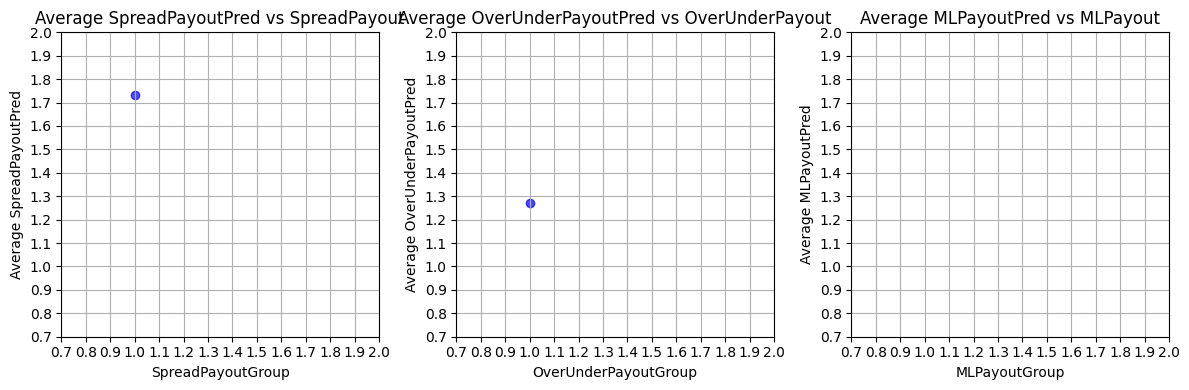

			Spread: 1.387					OverUnder: 0.813				Money Line: 0.0
Spread:     Average Payout: 1.38686, Sample Size: 5, P-Value: 0.33180536058418597, Significant No
OverUnder:  Average Payout: 0.81254, Sample Size: 7, P-Value: 0.6419473072923352, Significant No
ML:         Average Payout: 0.0, Sample Size: 6, P-Value: 0.0, Significant Yes


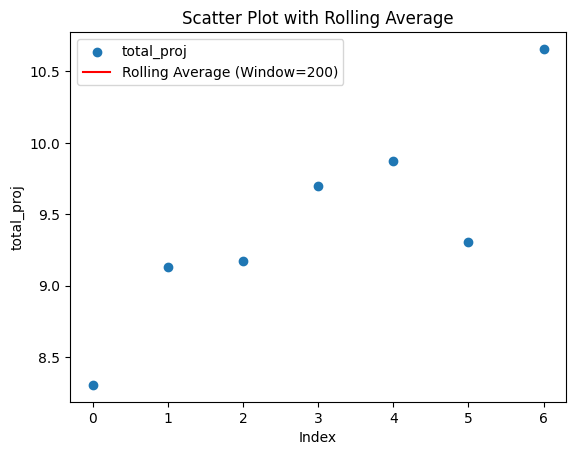

In [3]:
%run "C:\Users\james\Documents\MLB\Code\C01. Gambling.ipynb"

### Date Range

In [4]:
# Select date ranges
start_date = todaysdate
end_date = todaysdate
# start_date = "20220407"
# end_date = "20230917"


### Games

In [5]:
game_df = read_and_save_games(team_map, generate=True)

### Sims

In [6]:
# List of matchup folders within specified date
matchup_folders = os.listdir(os.path.join(baseball_path, "B02. Simulations", "1. Game Sims"))
matchup_folders = [date for date in matchup_folders if int(start_date) <= int(date[-8:]) <= int(end_date)]

In [7]:
%%time
# Create sim dataframe
game_sims_list = Parallel(n_jobs=-1)(delayed(daily_sim_scores)(matchup_folder) for matchup_folder in matchup_folders)
sim_df = pd.concat(game_sims_list, axis=0)

CPU times: total: 0 ns
Wall time: 6.11 s


In [8]:
sim_df = sim_df.merge(team_map[['BASEBALLPRESSTEAM', 'BBREFTEAM']], left_on=['VisitorTeamShort'], right_on=['BASEBALLPRESSTEAM'], how='left')

### Odds

In [9]:
# Loop over unique dates features in simulation results
odds_files = []
for date in list(sim_df['date'].unique()):
    try:
        # read_odds is fantasylabs, read_odds2 is Odds API (deprecated), and read_odds3 is Sportsbook Review (preferred)
        daily_odds_df = read_odds3(date)
        odds_files.append(daily_odds_df)
    except:
        pass

# Create dataframe
odds_df = pd.concat(odds_files, axis=0).reset_index(drop=True)
odds_df['date'] = odds_df['date'].astype(int)

In [10]:
odds_df = odds_df.merge(team_map[['SFBBTEAM', 'BBREFTEAM']], left_on=['VisitorTeamShort'], right_on=['SFBBTEAM'], how='left')
len(odds_df['BBREFTEAM'].unique())

15

### Merge

In [11]:
# Merge sims with actual results
gambling_df = pd.merge(sim_df, game_df, on='game_id', how='left', suffixes=("", "_act"))
# Merge with gambling information
gambling_df = pd.merge(gambling_df, odds_df, on=['date', 'game_num', 'BBREFTEAM'], how='inner')

### Calculate Stats

In [12]:
# Calculate gambling payouts
gambling_df = gambling_stats_games(gambling_df)
# Calculate errors and MSEs in runs
gambling_df = vegas_runs(gambling_df)
# Add spread
gambling_df['SpreadAct'] = gambling_df[['AwaySpreadAct', 'HomeSpreadAct']].sum(axis=1)
# Add spread side
gambling_df['SpreadSide'] = gambling_df.apply(determine_spread_side, axis=1)
# Add total runs
gambling_df['TotalModelRuns'] = gambling_df[['VisitorModelRuns', 'HomeModelRuns']].sum(axis=1)

### Clean

In [13]:
# Drop first instance of games that were postponed
gambling_df.drop_duplicates(subset=['game_id'], keep='last', inplace=True)
gambling_df.reset_index(inplace=True, drop=True)

### Results

In [14]:
gambling_df[['away_team', 'home_team', 'VisitorModelRuns', 'HomeModelRuns', 'TotalModelRuns', 
             'OU', 'OuMoney1', 'OuMoney2', 'Spread', 'AwaySpreadPred', 'HomeSpreadPred', 
             'OverPred', 'UnderPred', 'AwayMLPred', 'HomeMLPred']].head(15)

,away_team,home_team,VisitorModelRuns,HomeModelRuns,TotalModelRuns,OU,OuMoney1,OuMoney2,Spread,AwaySpreadPred,HomeSpreadPred,OverPred,UnderPred,AwayMLPred,HomeMLPred
0,CHW,TOR,3.906746,4.398810,8.305556,7.000000,1.925926,1.892857,-1.500000,1.048244,0.851329,1.139330,0.783801,1.073016,0.893188
1,BAL,STL,4.793651,4.337302,9.130952,9.000000,1.909091,1.909091,1.500000,0.841667,1.061475,0.878066,1.040945,0.868007,1.093373
2,COL,OAK,4.219246,4.950397,9.169643,7.500000,1.833333,2.000000,-1.500000,0.860029,1.131429,1.129464,0.767857,0.816667,1.081197
3,SEA,NYY,4.493056,5.204365,9.697421,8.500000,1.980392,1.847458,-1.500000,0.969470,0.944643,1.121829,0.800932,1.009087,0.925767
4,DET,KCR,4.902778,4.967262,9.870040,9.000000,1.980392,1.847458,1.500000,0.841627,1.030084,1.082808,0.848265,0.885157,1.021955
5,LAA,HOU,4.343254,4.964286,9.307540,9.000000,1.909091,1.909091,-1.500000,1.054894,0.849206,0.907377,1.013438,1.063333,0.898850
6,ATL,CHC,5.711310,4.946429,10.657738,11.500000,1.952381,1.869565,1.500000,0.944742,0.972259,0.720522,1.179607,0.961844,0.958333


In [15]:
# Where are the white sox?

### Evaluations

In [16]:
print(gambling_df[gambling_df['date'] <= int(end_date)]['OverUnderPick'].value_counts())

OverUnderPick
Over     4
Under    3
Name: count, dtype: int64


In [17]:
print(gambling_df[gambling_df['date'] <= int(end_date)]['SpreadSide'].value_counts())

SpreadSide
Underdog    4
Neither     2
Favorite    1
Name: count, dtype: int64


##### Vegas Runs

In [18]:
gambling_df[['VisitorModelRuns', 'HomeModelRuns', 'VisitorVegasRuns', 'HomeVegasRuns', 'away_score_act', 'home_score_act', 'VisitorModelSqError', 'HomeModelSqError', 'VisitorVegasSqError', 'HomeVegasSqError']].describe()

,VisitorModelRuns,HomeModelRuns,VisitorVegasRuns,HomeVegasRuns,away_score_act,home_score_act,VisitorModelSqError,HomeModelSqError,VisitorVegasSqError,HomeVegasSqError
count,13.000000,13.000000,0.000000,0.000000,13.000000,13.000000,13.000000,13.000000,0.000000,0.000000
mean,4.384844,4.645070,NaN,NaN,0.000000,0.000000,19.299248,21.870506,NaN,NaN
std,0.280037,0.564194,NaN,NaN,0.000000,0.000000,2.493395,5.366306,NaN,NaN
min,3.960317,3.880952,NaN,NaN,0.000000,0.000000,15.684114,15.061791,NaN,NaN
25%,4.206349,4.165675,NaN,NaN,0.000000,0.000000,17.693374,17.352845,NaN,NaN
50%,4.342262,4.699405,NaN,NaN,0.000000,0.000000,18.855238,22.084405,NaN,NaN
75%,4.519841,4.964286,NaN,NaN,0.000000,0.000000,20.428965,24.644133,NaN,NaN
max,4.961310,5.831349,NaN,NaN,0.000000,0.000000,24.614592,34.004634,NaN,NaN


##### Graph Payouts

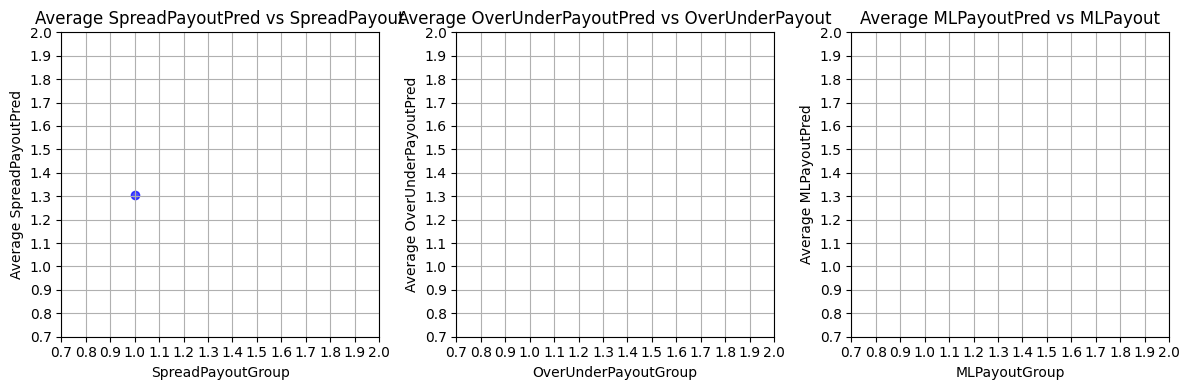

			Spread: 1.383					OverUnder: 0.0				Money Line: 0.0


In [19]:
# Create a single row with three subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Call the function for each subplot
payout_plotter(gambling_df.query(f"date <= {end_date}"), 'Spread', ax=axes[0])
payout_plotter(gambling_df.query(f"date <= {end_date}"), 'OverUnder', ax=axes[1])
payout_plotter(gambling_df.query(f"date <= {end_date}"), 'ML', ax=axes[2])

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

SpreadMean = gambling_df.query(f'date <= {end_date}')['SpreadPayout'].mean()
OverUnderMean = gambling_df.query(f'date <= {end_date}')['OverUnderPayout'].mean()
MLMean = gambling_df.query(f'date <= {end_date}')['MLPayout'].mean()
print(f"\t\t\tSpread: {round(SpreadMean, 3)}\t\t\t\t\tOverUnder: {round(OverUnderMean, 3)}\t\t\t\tMoney Line: {round(MLMean, 3)}")

In [20]:
print("Spread"), significance_test(gambling_df.query(f'(date <= {end_date})'), "Spread", 1.0, 0.05)
print("OverUnder"), significance_test(gambling_df.query(f'(date <= {end_date})'), "OverUnder", 1.0, 0.05)
print("ML"), significance_test(gambling_df.query(f'(date <= {end_date})'), "ML", 1.0, 0.05)

Spread
OverUnder
ML


(None, (0.0, 10, 0.0, 'Yes'))

In [21]:
print("Favorite"), significance_test(gambling_df.query(f'(date <= {end_date}) and ((SpreadPick == "Away" and Spread > 0) or (SpreadPick == "Home" and Spread < 0))'), "Spread", 1.0, 0.05)
print("Underdog"), significance_test(gambling_df.query(f'(date <= {end_date}) and ((SpreadPick == "Away" and Spread < 0) or (SpreadPick == "Home" and Spread > 0))'), "Spread", 1.0, 0.05)

Favorite
Underdog


(None, (1.72893, 8, 1.6657445729252203e-05, 'Yes'))

In [22]:
# Calculate average score differential between teams
# I tend to predict closer matchups, so I'd like to try to better replicate Vegas
gambling_df['ModelDiff'] = (gambling_df['VisitorModelRuns'] - gambling_df['HomeModelRuns']).abs()
gambling_df['VegasDiff'] = (gambling_df['VisitorVegasRuns'] - gambling_df['HomeVegasRuns']).abs()
gambling_df.describe()

,game_id,date,game_num,VisitorModelRuns,HomeModelRuns,away_id,home_id,game_num_act,away_score_act,home_score_act,venue_id,Spread,OU,SpreadMoney1,SpreadMoney2,OuMoney1,OuMoney2,MLMoney1,MLMoney2,VisitorVegasRuns,HomeVegasRuns,total_proj,over_proj,under_proj,push_proj,total_act,over_act,under_act,push_act,away_sp_proj,home_sp_proj,push_sp_proj,away_sp_act,home_sp_act,push_sp_act,away_ml_proj,home_ml_proj,away_ml_act,home_ml_act,AwaySpreadPred,HomeSpreadPred,OverPred,UnderPred,AwayMLPred,HomeMLPred,AwaySpreadAct,HomeSpreadAct,OverAct,UnderAct,AwayMLAct,HomeMLAct,SpreadPayout,OverUnderPayout,MLPayout,SpreadPayoutPred,OverUnderPayoutPred,MLPayoutPred,VisitorModelError,VisitorVegasError,VisitorModelSqError,VisitorVegasSqError,HomeModelError,HomeVegasError,HomeModelSqError,HomeVegasSqError,TotalVegasRuns,SpreadAct,TotalModelRuns,ModelDiff,VegasDiff
count,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,0.000000,0.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,10.000000,9.000000,10.000000,10.000000,9.000000,10.000000,13.000000,0.000000,13.000000,0.000000,13.000000,0.000000,13.000000,0.000000,0.000000,13.000000,13.000000,13.000000,0.000000
mean,746086.307692,20240517.000000,1.000000,4.384844,4.645070,128.615385,129.230769,1.000000,0.000000,0.000000,1942.538462,-0.576923,8.076923,1.943055,2.014039,1.926347,1.896884,2.316120,1.706784,NaN,NaN,9.029915,0.530296,0.433532,0.036172,0.000000,0.000000,1.000000,0.000000,0.532738,0.467262,0.000000,0.692308,0.307692,0.000000,0.452076,0.547924,0.000000,0.000000,1.001365,0.905863,1.057352,0.857446,1.019429,0.920764,1.203825,0.491607,0.000000,1.896884,0.000000,0.000000,1.383140,0.000000,0.000000,1.050303,1.099412,1.069866,4.384844,NaN,19.299248,NaN,4.645070,NaN,21.870506,NaN,NaN,1.695432,9.029915,0.664683,NaN
std,798.436011,0.000000,0.000000,0.280037,0.564194,15.585990,14.714810,0.000000,0.000000,0.000000,2033.044704,1.441153,0.493548,0.359326,0.378836,0.049495,0.046051,0.459091,0.239601,NaN,NaN,0.485932,0.056969,0.049865,0.048001,0.000000,0.000000,0.000000,0.000000,0.109228,0.109228,0.000000,0.480384,0.480384,0.000000,0.075315,0.075315,0.000000,0.000000,0.084092,0.077667,0.086458,0.086593,0.089294,0.068022,0.849725,0.767990,0.000000,0.046051,0.000000,0.000000,0.749706,0.000000,0.000000,0.034951,0.066214,0.040744,0.280037,NaN,2.493395,NaN,0.564194,NaN,5.366306,NaN,NaN,0.172017,0.485932,0.389977,NaN
min,744934.000000,20240517.000000,1.000000,3.960317,3.880952,108.000000,109.000000,1.000000,0.000000,0.000000,2.000000,-1.500000,7.500000,1.520833,1.555556,1.869565,1.819672,1.740741,1.350877,NaN,NaN,8.155754,0.449405,0.358135,0.000000,0.000000,0.000000,1.000000,0.000000,0.338294,0.317460,0.000000,0.000000,0.000000,0.000000,0.336310,0.413690,0.000000,0.000000,0.845734,0.811389,0.918561,0.706651,0.844503,0.827381,0.000000,0.000000,0.000000,1.819672,0.000000,0.000000,0.000000,0.000000,0.000000,1.001786,1.012004,1.003408,3.960317,NaN,15.684114,NaN,3.880952,NaN,15.061791,NaN,NaN,1.520833,8.155754,0.099206,NaN
25%,745335.000000,20240517.000000,1.000000,4.206349,4.165675,115.000000,117.000000,1.000000,0.000000,0.000000,14.000000,-1.500000,7.500000,1.675676,1.675676,1.869565,1.869565,1.925926,1.505051,NaN,NaN,8.803571,0.481151,0.391865,0.000000,0.000000,0.000000,1.000000,0.000000,0.443452,0.395833,0.000000,0.000000,0.000000,0.000000,0.406746,0.496032,0.000000,0.000000,0.970479,0.831250,0.989418,0.799414,0.983333,0.887950,0.000000,0.000000,0.000000,1.869565,0.000000,0.000000,1.525760,0.000000,0.000000,1.031859,1.062854,1.048526,4.206349,NaN,17.693374,NaN,4.165675,NaN,17.352845,NaN,NaN,1.555556,8.803571,0.393849,NaN
50%,7

In [23]:
gambling_df['VisitorModelRuns'].mean()

4.384844322344322

##### Graph Runs

In [24]:
gambling_df['toohigh'] = (gambling_df['total_proj'] > gambling_df['OU']).astype('int')

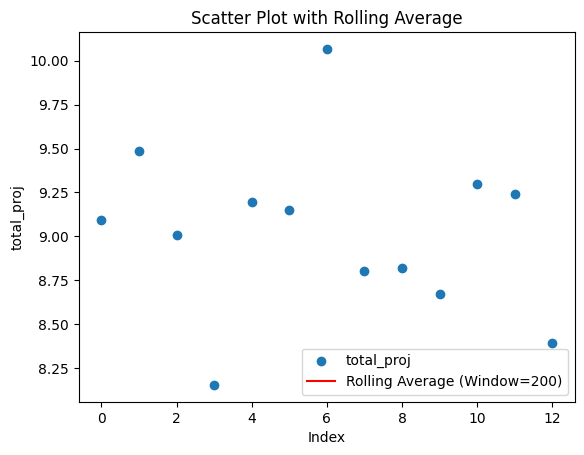

In [25]:
# Total: Choose Vegas or Actual to compare my runs to 
# total = "TotalVegasRuns"
total = "total_act"

gambling_df = gambling_df.sort_values('date', ascending=True).reset_index(drop=True)

# You can convert the index to a list for the x-axis and get the values for the y-axis
x_values = gambling_df.index.tolist()
y_values = gambling_df['total_proj'].tolist()

# Calculate the rolling average
rolling_avg = gambling_df[f'{total}'].rolling(window=200, min_periods=100).mean()

# Create a scatter plot
plt.scatter(x_values, y_values, label='total_proj')

# Add the rolling average line
plt.plot(x_values, rolling_avg, color='red', label='Rolling Average (Window=200)')

# Set labels and title
plt.xlabel('Index')
plt.ylabel('total_proj')
plt.title('Scatter Plot with Rolling Average')
plt.legend()

# Show the plot
plt.show()

### C02. Projections

In [ ]:
%run "C:\Users\james\Documents\MLB\Code\C02. Projections.ipynb"

In [ ]:
# Read in guide
contestKey = 160396665
guide = pd.read_csv(os.path.join(baseball_path, "A09. Contest Guides", f"Contest Guide {contestKey}.csv"))

### Pre

##### Read in Projections

In [ ]:
my_projections = read_my_projections(guide, contestKey)
dff_projections = read_dff_projections(guide)
roto_projections = read_roto_projections(guide)

##### Merge Projections

In [ ]:
projections_df = pd.merge(my_projections[['Name', 'Position', 'imp_l', 'imp_r', 'Projection_Me']], dff_projections, on='Name', how='outer')
projections_df = pd.merge(projections_df, roto_projections, on='Name', how='outer')
valid_projections_df = projections_df.dropna().query('Projection_Me > 0 and Projection_DFF > 0 and Projection_Roto > 0')

##### Evaluate Projections

In [ ]:
daily_evaluations = evaluate_projections_pre(valid_projections_df, quietly=False)

### Post

##### Read in Results

In [63]:
player_results_df = pd.read_csv(os.path.join(baseball_path, "A01. DraftKings", "6. Player Results", f"Player Results {contestKey}.csv"), encoding='iso-8859-1')
results_df = name_clean(player_results_df, "Player")
results_df = results_df[['Name', 'FPTS']]

##### Merge onto Projections

In [64]:
projections_and_results_df = projections_df.merge(results_df, on='Name', how='left')

##### Evaluate

In [65]:
projections_and_results_df = evaluate_projections_post(projections_and_results_df)
projections_and_results_df.drop_duplicates(subset='Name', keep=False).describe()

,imp_l,imp_r,Projection_Me,Projection_DFF,Projection_Roto,rostership,FPTS,error_Me,MSE_Me,error_DFF,MSE_DFF,error_Roto,MSE_Roto,beat_DFF,beat_Roto
count,250.000000,250.000000,250.000000,139.000000,422.000000,422.000000,191.000000,144.000000,144.000000,139.000000,139.000000,186.000000,186.000000,139.000000,186.000000
mean,0.072000,0.044000,4.909212,8.238129,3.158602,2.320190,5.051571,1.216297,37.649393,1.539209,39.325378,1.793065,32.567344,0.582734,0.462366
std,0.259006,0.205507,3.650298,2.350529,4.188922,4.388825,6.389858,6.035143,61.432001,6.101149,54.921373,5.432396,48.460291,0.494891,0.499927
min,0.000000,0.000000,0.003026,4.200000,0.000000,0.000000,0.000000,-22.977183,0.196650,-21.200000,0.000000,-20.330000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.529390,6.900000,0.000000,0.000000,0.000000,-1.749504,6.603001,-2.100000,7.290000,0.000000,4.378575,0.000000,0.000000
50%,0.000000,0.000000,5.805556,7.800000,0.000000,0.000000,3.000000,2.643279,20.735959,3.200000,22.090000,2.420000,15.642650,1.000000,0.000000
75%,0.000000,0.000000,7.215526,8.900000,7.170000,2.552500,8.000000,5.718998,42.544470,6.050000,52.565000,5.825000,46.785600,1.000000,1.000000
max,1.000000,1.000000,18.103125,18.100000,19.450000,33.390000,30.000000,10.418403,527.950917,10.300000,449.440000,10.320000,413.308900,1.000000,1.000000


### Historic

In [ ]:
# Create list of contestKeys with available guides
contestKey_list = os.listdir(os.path.join(baseball_path, "A09. Contest Guides"))
contestKey_list = [int(key.replace(".csv", "").split(" ")[2]) for key in contestKey_list]

# Create list of contestKeys with available results
result_contestKey_list = os.listdir(os.path.join(baseball_path, "A01. DraftKings", "6. Player Results"))
result_contestKey_list = [int(key.replace(".csv", "").split(" ")[2]) for key in result_contestKey_list]

# Find the overlap 
available_contestKey_list = list(set(result_contestKey_list) & set(contestKey_list))

In [ ]:
%%time
contest_projection_list = Parallel(n_jobs=-1)(delayed(run_contest_evaluation)(contestKey) for contestKey in available_contestKey_list)

In [ ]:
# Append 
all_contest_projections = pd.concat(contest_projection_list, axis=0)
# Drop duplicates
all_contest_projections.drop_duplicates(['Name', 'contestKey'], inplace=True)
# Maybe only read in stats for starter = 1 for pitchers?

### Evaluations

In [ ]:
batter_means = all_contest_projections.query('`Position` != "pitcher" and Projection_Me > 0 and Projection_DFF > 0 and Projection_Roto > 0').select_dtypes(include=['number']).agg('mean')
pitcher_means = all_contest_projections.query('FPTS != 0').query('`Position` == "pitcher" and Projection_Me > 0 and Projection_DFF > 0 and Projection_Roto > 0').select_dtypes(include=['number']).agg('mean')
all_means = all_contest_projections.query('Projection_Me > 0 and Projection_DFF > 0 and Projection_Roto > 0').select_dtypes(include=['number']).agg('mean')

batter_means_unimp = all_contest_projections.query('(imp_l == 0 and imp_r == 0) and `Position` != "pitcher" and Projection_Me > 0 and Projection_DFF > 0 and Projection_Roto > 0').select_dtypes(include=['number']).agg('mean')
pitcher_means_unimp = all_contest_projections.query('FPTS != 0').query('(imp_l == 0 and imp_r == 0) and `Position` == "pitcher" and Projection_Me > 0 and Projection_DFF > 0 and Projection_Roto > 0').select_dtypes(include=['number']).agg('mean')
all_means_unimp = all_contest_projections.query('(imp_l == 0 and imp_r == 0) and Projection_Me > 0 and Projection_DFF > 0 and Projection_Roto > 0').select_dtypes(include=['number']).agg('mean')

batter_means_imp = all_contest_projections.query('(imp_l == 1 or imp_r == 1) and `Position` != "pitcher" and Projection_Me > 0 and Projection_DFF > 0 and Projection_Roto > 0').select_dtypes(include=['number']).agg('mean')
pitcher_means_imp = all_contest_projections.query('FPTS != 0').query('(imp_l == 1 or imp_r == 1) and `Position` == "pitcher" and Projection_Me > 0 and Projection_DFF > 0 and Projection_Roto > 0').select_dtypes(include=['number']).agg('mean')
all_means_imp = all_contest_projections.query('(imp_l == 1 or imp_r == 1) and Projection_Me > 0 and Projection_DFF > 0 and Projection_Roto > 0').select_dtypes(include=['number']).agg('mean')

means_df = pd.concat([batter_means, pitcher_means, all_means, batter_means_unimp, pitcher_means_unimp, all_means_unimp, batter_means_imp, pitcher_means_imp, all_means_imp], axis=1).T
means_df.set_index(pd.Index(["Batters", "Pitchers", "All", "Batters Unimp", "Pitchers Unimp", "All Unimp", "Batters Imp", "Pitchers Imp", "All Imp"]), inplace=True)
means_df.drop(columns={'imp_l', 'imp_r', 'rostership', 'date', 'contestKey'})

In [ ]:
batter_means = all_contest_projections.query('`Position` != "pitcher" and Projection_Me > 5 and Projection_DFF > 5 and Projection_Roto > 5').select_dtypes(include=['number']).agg('mean')
pitcher_means = all_contest_projections.query('FPTS != 0').query('`Position` == "pitcher" and Projection_Me > 10 and Projection_DFF > 10 and Projection_Roto > 10').select_dtypes(include=['number']).agg('mean')
all_means = all_contest_projections.query('Projection_Me > 5 and Projection_DFF > 5 and Projection_Roto > 5').select_dtypes(include=['number']).agg('mean')

batter_means_unimp = all_contest_projections.query('(imp_l == 0 and imp_r == 0) and `Position` != "pitcher" and Projection_Me > 5 and Projection_DFF > 5 and Projection_Roto > 5').select_dtypes(include=['number']).agg('mean')
pitcher_means_unimp = all_contest_projections.query('FPTS != 0').query('(imp_l == 0 and imp_r == 0) and `Position` == "pitcher" and Projection_Me > 10 and Projection_DFF > 10 and Projection_Roto > 10').select_dtypes(include=['number']).agg('mean')
all_means_unimp = all_contest_projections.query('(imp_l == 0 and imp_r == 0) and Projection_Me > 5 and Projection_DFF > 5 and Projection_Roto > 5').select_dtypes(include=['number']).agg('mean')

batter_means_imp = all_contest_projections.query('(imp_l == 1 or imp_r == 1) and `Position` != "pitcher" and Projection_Me > 5 and Projection_DFF > 5 and Projection_Roto > 5').select_dtypes(include=['number']).agg('mean')
pitcher_means_imp = all_contest_projections.query('FPTS != 0').query('(imp_l == 1 or imp_r == 1) and `Position` == "pitcher" and Projection_Me > 10 and Projection_DFF > 10 and Projection_Roto > 10').select_dtypes(include=['number']).agg('mean')
all_means_imp = all_contest_projections.query('(imp_l == 1 or imp_r == 1) and Projection_Me > 5 and Projection_DFF > 5 and Projection_Roto > 5').select_dtypes(include=['number']).agg('mean')

means_df = pd.concat([batter_means, pitcher_means, all_means, batter_means_unimp, pitcher_means_unimp, all_means_unimp, batter_means_imp, pitcher_means_imp, all_means_imp], axis=1).T
means_df.set_index(pd.Index(["Batters", "Pitchers", "All", "Batters Unimp", "Pitchers Unimp", "All Unimp", "Batters Imp", "Pitchers Imp", "All Imp"]), inplace=True)
means_df.drop(columns={'imp_l', 'imp_r', 'rostership', 'date', 'contestKey'})

In [ ]:
# all_contest_projections.query('Position == "pitcher"').query('Projection_Roto > 5').query('MSE_Me > MSE_DFF + 50').head(50)

In [ ]:
breakff

### C03. Payouts

In [ ]:
%run "C:\Users\james\Documents\MLB\Code\C03. Payouts.ipynb"

##### Testable contestKeys

In [ ]:
# Create list of contestKeys with available guides
contestKey_list = os.listdir(os.path.join(baseball_path, "A09. Contest Guides"))
contestKey_list = [int(key.replace(".csv", "").split(" ")[2]) for key in contestKey_list]

# Create list of contestKeys with available results
result_contestKey_list = os.listdir(os.path.join(baseball_path, "A01. DraftKings", "6. Player Results"))
result_contestKey_list = [int(key.replace(".csv", "").split(" ")[2]) for key in result_contestKey_list]

# Find the overlap 
available_contestKey_list = list(set(result_contestKey_list) & set(contestKey_list))

##### Assign payouts to contests

In [ ]:
%%time
sims_list = Parallel(n_jobs=-1, verbose=1)(delayed(calculate_lineup_returns2)(contestKey) for contestKey in available_contestKey_list)
all_sims_df = pd.concat(sims_list, axis=0)

Drop observations with missing values for player scores

In [ ]:
all_sims_df2 = all_sims_df.dropna()

Add metrics to measure performance.

In [ ]:
all_sims_df2 = add_metrics(all_sims_df2)

##### Evaluate Metrics

In [ ]:
metrics = ['AvgPointsPerGame', 'Sim STD', 'Plus2', 'Plus3', 'Tail', 'Rarity', 'Batter', 'Pitcher', 'Choose', 'Choose2']
lineups = 20
for metric in metrics:
    # print(metric)
    ranked_metric = metric + " Rank"
    profit = evaluate_metric(all_sims_df2, ranked_metric, lineups)
    print("With the {} metric, the top {} lineups would average a profit of {:.2f}.".format(metric, lineups, profit))

##### Plot Performance

In [ ]:
plot_payouts(all_sims_df2, "Tail")

##### Pareto Optimality

In [ ]:
all_sims_df2['pareto'] = paretoset(all_sims_df2[["AvgPointsPerGame", "Sim STD", 'batter rostership', 'contestKey']], sense=['max', 'max', 'min', 'diff']).astype('int')

In [ ]:
all_sims_df2['ReturnBig'] = (all_sims_df2['Return'] > 4).astype('int')

In [ ]:
all_sims_df2.groupby('pareto')[['Return', 'ReturnBig', 'Payout']].agg(['mean', 'sum'])

In [ ]:
all_sims_df2.query('Payout > 1000')['contestKey'].value_counts()

Determine profitability along pareto curve.

In [ ]:
# Inputs
variable = "Sim STD"
return_metric = "ReturnBig"

# Filter the DataFrame where pareto equals 1 and calculate percentiles of variable within each contestKey
grouped_df = all_sims_df2.loc[all_sims_df2['pareto'] == 1].groupby('contestKey')[f'{variable}'].transform(lambda x: x.rank(pct=True))

# Define the number of buckets (e.g., 10 buckets of 10% each)
num_buckets = 10
bucket_size = 1.0 / num_buckets

# Create buckets of percentiles and calculate the average Return within each bucket
grouped_df = (all_sims_df2.loc[all_sims_df2['pareto'] == 1]
              .assign(Percentile_Bucket=pd.cut(grouped_df, bins=[i*bucket_size for i in range(num_buckets+1)], labels=[f'{i*10}-{(i+1)*10}%' for i in range(num_buckets)]))
              .groupby('Percentile_Bucket')[f'{return_metric}'].mean())

# Plot the grouped data
grouped_df.plot(kind='bar')
plt.xlabel(f'{variable} Percentile Bucket')
plt.ylabel(f'Average {return_metric}')
plt.title(f'Average {return_metric} vs. {variable} Percentile Bucket')
plt.xticks(rotation=45)
plt.show()
